##### EDA

In [2]:
import torchxrayvision as xrv

C:\Program Files\Python312\Lib\site-packages\torchxrayvision\utils.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
d = xrv.datasets.COVID19_Dataset(imgpath="data/images/", csvpath="data/csv/metadata.csv")

In [4]:
img = d[0]['img'][0]
print(f"sample image of shape {img.shape}")
print(f"dataset of length {len(d)}")
print(img)

sample image of shape (888, 882)
dataset of length 535
[[1024.      1015.9686  1007.93726 ... -469.83527 -477.86664 -477.86664]
 [1024.      1024.      1015.9686  ... -493.92938 -493.92938 -493.92938]
 [1024.      1024.      1015.9686  ... -501.96075 -509.99213 -509.99213]
 ...
 [1024.      1024.       983.84314 ... -172.6745  -156.61176 -148.58038]
 [1024.      1024.       983.84314 ... -252.98822 -244.95685 -244.95685]
 [1024.      1024.       983.84314 ... -437.70978 -429.6784  -421.64703]]


##### SummaryWriter

In [1]:
from torch.utils.tensorboard import SummaryWriter
import torchvision
writer1 = SummaryWriter("logs/COVID19_train")
writer2 = SummaryWriter("logs/COVID19_test")

##### Dataloader

In [2]:
from dataLoader import *
from torch.utils.data import DataLoader

C:\Users\Hoo Kai Sng\OneDrive - National University of Singapore\Documents\NUS\CS3244\Project\xrayenv\Lib\site-packages\torchxrayvision\utils.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# train_dataset = Covid19DataSet('train', transform = 'vanilla')
augmented_dataset = Covid19DataSet('train', transform = 'augment')
validation_dataset = Covid19DataSet('val', transform = 'vanilla')
test_dataset = Covid19DataSet('test', transform = 'vanilla')

In [4]:
BATCH_SIZE = 8
train_loader = DataLoader(dataset = augmented_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)

In [5]:
# from PIL import Image
# import torchvision.transforms as transforms
# d = xrv.datasets.COVID19_Dataset(imgpath = "data/images/", csvpath = "data/csv/metadata.csv")
# img = d[0]['img'][0]
# img = img + 1024
# img = np.divide(img, 2048)
# pil = Image.fromarray(img)
# ld = transforms.ToTensor()
# tensor = ld(pil)
# compose = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.RandomHorizontalFlip(p = 1),
#     transforms.ToTensor(), 
# ])
# tensor2 = compose(pil)
# print(tensor2)

##### Building of model

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import models

class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(4, 16, 5)

        self.fc1 = nn.Linear(16 * 12 * 12, 576)
        self.fc2 = nn.Linear(576, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ConvNetGlobPooling(nn.Module):

    def __init__(self):
        super(ConvNetGlobPooling, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(4, 16, 5)
        
        # Global Average Pooling (replaces flattening)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        self.fc1 = nn.Linear(16, 128)  # Adjusted to match the output from global pooling
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Apply global average pooling (or change to max pooling if needed)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MyResNet18(nn.Module):
    def __init__(self):
        super(MyResNet18, self).__init__()
        self.resnet = models.resnet18(weights = 'DEFAULT')
        with torch.no_grad():
            self.resnet.conv1.weight = nn.Parameter(self.resnet.conv1.weight.mean(dim = 1, keepdim = True))
        for params in self.resnet.parameters():
            params.requires_grad = False
        num_features = self.resnet.fc.in_features
        self.features = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4
        )
        self.avgpool = self.resnet.avgpool
        self.fc = nn.Linear(num_features, 1)
        self.gradients = None

    def forward(self, x):
        x = self.features(x)
        # Activate hook right after gradient calculated 
        if not self.training and x.requires_grad:
            h = x.register_hook(self.activations_hook)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
    def activations_hook(self, grad):
        self.gradients = grad

    def get_activation_gradients(self):
        if self.gradients is None:
            print("Gradient is not set")
        else:
            return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    

In [24]:
model = MyResNet18()

##### Training Model

In [25]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

# Creates a tensorboard scalar at the same time
def train_model(model, train_loader, validation_loader, writer1, writer2, epochs = 5, learning_rate = 0.1, grad_criterion = nn.BCEWithLogitsLoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.8, patience = 1)
    best_model, best_loss, best_acc = copy.deepcopy(model.state_dict()), 9999.9, 0.0
    starttime = time.time()
    
    print("Training model")

    for epoch in range(epochs):
        t_loss, v_loss, t_acc, v_acc = [], [], [], []

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()  
        
            target_loader = train_loader if phase == 'train' else validation_loader
            n_total = running_correct = epoch_loss = 0.0
        
            for i, (images, labels) in enumerate(target_loader):
                n_total += images.size(dim = 0)

                with torch.set_grad_enabled(phase == 'train'):
                    # forward pass
                    y_preds = model(images)
                    pred_labels = (torch.sigmoid(y_preds) >= 0.5)
                    loss = grad_criterion(y_preds, labels)
                    epoch_loss += loss.item()
                    running_correct += (pred_labels == labels).sum().item()

                    if phase == 'train':
                        # backward prop
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

            if phase == 'train':
                avg_loss, avg_correct = epoch_loss / n_total, running_correct / n_total
                t_loss.append(avg_loss)
                t_acc.append(avg_correct)
                # scheduler step
                scheduler.step(epoch_loss)    

            if phase == 'val':
                avg_loss, avg_correct = epoch_loss / n_total, running_correct / n_total
                v_loss.append(avg_loss)
                v_acc.append(avg_correct)
                if avg_loss < best_loss:
                    best_loss, best_acc = avg_loss, avg_correct
                    best_model = copy.deepcopy(model.state_dict())
            
        print(f"Epoch [{epoch + 1}/{epochs}] |Training Loss: {t_loss[-1]:.4f} | Validation Loss: {v_loss[-1]:.4f}")
        writer1.add_scalar('loss', t_loss[-1], epoch+1)
        writer1.add_scalar('acc', t_acc[-1], epoch+1)
        writer2.add_scalar('loss', v_loss[-1], epoch+1)
        writer2.add_scalar('acc', v_acc[-1], epoch+1)

    writer1.close()
    writer2.close()
    
    elapsedtime = time.time() - starttime
    mins, sec = elapsedtime//60, elapsedtime%60
    print(f"Training completed in {mins:.0f}mins {sec:.2f}s")
    print(f"Best Loss: {best_loss:.4f} | Best Accuracy: {(best_acc * 100):.0f}%")

    model.load_state_dict(best_model)
    return model
    
# Creates a tensorboard AUC curve at the same time
def get_metrics(model, test_loader, writer):
    model.eval()
    time_s = time.time()
    g_lab, preds = [], []
    with torch.no_grad():
        tp = tn = fp = fn = t = f = n = 0
        for j, (images, labels) in enumerate(test_loader):

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            y_preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            k = y_preds.size(dim = 0)
            n += k

            for i in range(k):
                pred_val, label_val = y_preds[i].item(), labels[i].item()
                tp += (pred_val == label_val == 1)
                tn += (pred_val == label_val == 0)
                fp += (pred_val == 1 and label_val == 0)
                fn += (pred_val == 0 and label_val == 1)
                f += (pred_val == 0)
                t += (pred_val == 1)

            preds.append(probs)
            g_lab.append(labels)

        preds = torch.cat(preds, dim = 0) if len(preds) > 1 else torch.tensor(preds[0]) # These are probabilities in order to match the pr curve
        g_lab = torch.cat(g_lab, dim = 0) if len(g_lab) > 1 else torch.tensor(labels[0])

        writer.add_pr_curve('covid19', g_lab, preds, 0)
        writer.close()

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    print(f"Precision: {prec} | Recall: {recall} | Positives: {t} | Negatives: {f} | Total: {n}")
    run_time = time.time() - time_s
    print(f"Time taken: {run_time:.2f}s")
    return recall, prec, t, f, n

In [26]:
resnet_trained = train_model(model, train_loader, validation_loader, writer1, writer2)

Training model
Epoch [1/5] |Training Loss: 0.7279 | Validation Loss: 0.2177
Epoch [2/5] |Training Loss: 0.2835 | Validation Loss: 0.0743
Epoch [3/5] |Training Loss: 0.3209 | Validation Loss: 0.0812
Epoch [4/5] |Training Loss: 0.3112 | Validation Loss: 0.0609
Epoch [5/5] |Training Loss: 0.1485 | Validation Loss: 0.2832
Training completed in 5mins 44.75s
Best Loss: 0.0609 | Best Accuracy: 90%


##### Evaluation

In [27]:
recall, prec, t, f, n = get_metrics(resnet_trained, test_loader, writer1)

Precision: 0.8817204301075269 | Recall: 0.9879518072289156 | Positives: 93 | Negatives: 14 | Total: 107
Time taken: 27.09s


##### Visualisation

In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

# Note that input_tensor can be a batch of images in a tensor
def infer(model, input_tensor):

    model.eval()
    outputs = model(input_tensor)
    prob = torch.sigmoid(outputs)
    labels = (prob >= 0.5).float()

    for i in range(prob.size(dim=1)):
        print(f"Predicted img {i} {'positive' if labels[i].item() == 1 else 'negative'} with probability {prob[i].item():.4f}")

    return outputs
    
def get_cam(model, outputs, input):

    time_s = time.time()
    print("Generating heatmap")
    
    # Unfreeze gradients for convolution layers
    for param in model.parameters():
        param.requires_grad = True
        
    model.eval()

    # 1.Extract targeted layer
    activations = model.get_activations(input)

    # 2. Set a hook at targeted_layer
    h = activations.register_hook(model.activations_hook)

    # 3. get the gradient of the output with respect to the parameters of the model
    outputs.backward()

    # 4. pull the gradients out of the model
    gradients = model.get_activation_gradients()
    activations = activations.detach()

    # 5. pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim = [0, 2, 3])


    # 6. weight the channels by corresponding gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    #   average the channels of the activations
    heatmap = torch.mean(activations, dim = 1).squeeze()

    # 7. relu on top of the heatmap
    #   expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)    # Similar to calling relu

    # 8. normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.squeeze())
    run_time = time.time() - time_s
    print(f"Heatmap generated in {run_time:.2f}s")
    return heatmap

def overlay_cam(heatmap, img_numpy):
    # Convert the heatmap to a numpy array and resize to match the input image
    heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (img_numpy.shape[1], img_numpy.shape[0]))
    
    # Normalize heatmap to be in range [0, 255] and apply colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose heatmap on the original image
    img_numpy = np.expand_dims(img_numpy, axis = 2)
    # superimposed_img = heatmap * 0.1 + img_numpy
    # superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Plot the superimposed image using matplotlib
    plt.imshow(img_numpy, cmap = 'gray')
    plt.imshow(heatmap, alpha=0.3)
    plt.axis('off')
    plt.show()

    # return superimposed_img

In [29]:
vanilla_dataset = Covid19DataSet('train', transform = 'vanilla')
vanilla_loader = DataLoader(dataset = vanilla_dataset, batch_size = 1, shuffle = False, num_workers = 4)

d = xrv.datasets.COVID19_Dataset(imgpath = "data/images/", csvpath = "data/csv/metadata.csv")
img_numpy = d[0]['img'][0]

gen = iter(vanilla_loader)
sample_img, sample_labels = next(gen)
img_grid = torchvision.utils.make_grid(sample_img)
writer1.add_image('xray_images', img_grid)

Predicted img 0 positive with probability 1.0000
tensor([[17.2941]], grad_fn=<AddmmBackward0>)
Generating heatmap
Heatmap generated in 0.13s


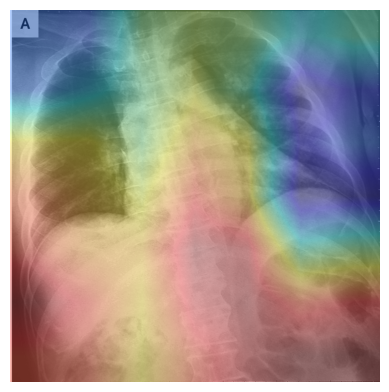

In [57]:
# Model visualisation with GradCam
sample_pred = infer(resnet_trained, sample_img)
# Create heatmap using cam
heatmap = get_cam(resnet_trained, sample_pred, sample_img)

# Show image with heatmap overlay
overlay_cam(heatmap, img_numpy)